In [1]:
import numpy as np
import xarray as xr
from odc.geo.xr import assign_crs, xr_reproject

from ocr import catalog
from ocr.risks.fire import create_weighted_composite_bp_map#, generate_wind_directional_kernels
from ocr.utils import geo_sel
import matplotlib.pyplot as plt
import typing
import warnings
import numpy as np
import numpy as np
import xarray as xr
from odc.geo.xr import assign_crs, xr_reproject
from scipy.ndimage import rotate

from ocr import catalog
from ocr.utils import geo_sel
import matplotlib.pyplot as plt

In [27]:
# griffith
lat = 34.15883207704988
lon = -118.3194545446337

# # altadena
# lat = 34.197179348047236
# lon = -118.14920706081259


## changes i made:
1. rotate to north, not south - account for the array being flipped from numpy -> xarray
2. don't do the indexing of the filter
3. size of gaussian filter (do we want this?)


## other things we could do
1. change rotate or add comment about how its not 0s/1s
2. confirm orientation of filter is right given the back and forth of projections

In [3]:
# y_slice = slice(34.14, 34.23)
# x_slice = slice(-118.18, -118.06)

from ocr.config import OCRConfig
config = OCRConfig(storage_root='/temp')

# y_slice = slice(34.14, 34.23)
# x_slice = slice(-118.18, -118.06)


region_id = 'y6_x7'
y_slice, x_slice = config.chunking.region_id_to_latlon_slices(region_id=region_id)
y_slice, x_slice



buffer = 0.15

buffered_x_slice = slice(x_slice.start - buffer, x_slice.stop + buffer, x_slice.step)
buffered_y_slice = slice(y_slice.start - buffer, y_slice.stop + buffer, y_slice.step)
riley_2011_270m_5070 = catalog.get_dataset('riley-et-al-2025-2011-270m-5070').to_xarray()[
    ['BP', 'spatial_ref']
]
riley_2011_270m_5070 = assign_crs(riley_2011_270m_5070, 'EPSG:5070')

bbox = (
    buffered_x_slice.start,
    buffered_y_slice.start,
    buffered_x_slice.stop,
    buffered_y_slice.stop,
)
riley_2011_270m_5070_subset = geo_sel(
    riley_2011_270m_5070,
    bbox=bbox,
    crs_wkt=riley_2011_270m_5070.spatial_ref.attrs['crs_wkt'],
)
wind_direction_distribution_30m_4326 = (
    catalog.get_dataset('conus404-ffwi-p99-wind-direction-distribution-30m-4326')
    .to_xarray()
    .wind_direction_distribution.sel(latitude=buffered_y_slice, longitude=buffered_x_slice)
    .load()
)

/Users/ori/code/ocr/.pixi/envs/default/lib/python3.13/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [4]:
def generate_weights(
    method: typing.Literal['skewed', 'circular_focal_mean'] = 'skewed',
    kernel_size: float = 81.0,
    circle_diameter: float = 35.0,
) -> np.ndarray:
    """Generate a 2D array of weights for a circular kernel.

    Parameters
    ----------
    method : str, optional
        The method to use for generating weights. Options are 'skewed' or 'circular_focal_mean'.
        'skewed' generates an elliptical kernel to simulate wind directionality.
        'circular_focal_mean' generates a circular kernel, by default 'skewed'
    kernel_size : float, optional
        The size of the kernel, by default 81.0
    circle_diameter : float, optional
        The diameter of the circle, by default 35.0

    Returns
    -------
    weights : np.ndarray
        A 2D array of weights for the circular kernel.
    """
    if method == 'circular_focal_mean':
        x, y = np.meshgrid(
            np.arange(-kernel_size // 2 + 1, kernel_size // 2 + 1),
            np.arange(-kernel_size // 2 + 1, kernel_size // 2 + 1),
        )
        distances = np.sqrt(x**2 + y**2)
        inside = distances <= circle_diameter // 2 + 1
        weights = inside / inside.sum()

    elif method == 'skewed':
        # elliptical kernel
        a = 4  # semi-major axis
        b = 2  # semi-minor axis
        x = np.linspace(-kernel_size // 2, kernel_size // 2 + 1, int(kernel_size))
        y = np.linspace(-kernel_size // 2, kernel_size // 2 + 1, int(kernel_size))
        xx, yy = np.meshgrid(x, y)

        # Ellipse equation
        ellipse = ((xx / a) ** 2 + (yy / b) ** 2) <= 10

        weights = np.roll(ellipse, -5)
        # Normalize to sum to 1.0 if there are any non-zero entries
        weights = weights.astype(np.float32)
        s = float(weights.sum())
        if s > 0:
            weights = weights / s

    else:
        raise ValueError(f'Unknown method: {method}')

    return weights

In [5]:
def generate_wind_directional_kernels(
    kernel_size: float = 81.0, circle_diameter: float = 35.0
) -> dict[str, np.ndarray]:
    """Generate a dictionary of 2D arrays of weights for circular kernels oriented in different directions.

    Parameters
    ----------
    kernel_size : float, optional
        The size of the kernel, by default 81.0
    circle_diameter : float, optional
        The diameter of the circle, by default 35.0

    Returns
    -------
    kernels : dict[str, np.ndarray]
        A dictionary of 2D arrays of weights for circular kernels oriented in different directions.
    """
    weights_dict = {}
    rotating_angles = np.arange(0, 360, 45)
    wind_direction_labels = ['W', 'NW', 'N', 'NE', 'E', 'SE', 'S', 'SW']
    for angle, direction in zip(rotating_angles, wind_direction_labels):
        base = generate_weights(
            method='skewed', kernel_size=kernel_size, circle_diameter=circle_diameter
        ).astype(np.float32)
        rotated = rotate(
            base,
            angle=angle,
            reshape=False,  # keep original shape
            order=1,  # bilinear to reduce ringing
            mode='nearest',
            prefilter=False,
        )

        # if angle in [45, 135, 225, 315]:
        #     # TODO, @orianac, i presume this cropping only applies to kernel_size=81.0, circle_diameter=35.0. If so, what should the cropping be for other kernel sizes and circle diameters?
        #     rotated = rotated[17:98, 17:98]

        # Remove tiny negative interpolation artifacts, renormalize
        rotated = np.clip(rotated, 0.0, None)
        weights_dict[direction] = rotated

    circ = generate_weights(
        method='circular_focal_mean',
        kernel_size=kernel_size,
        circle_diameter=circle_diameter,
    ).astype(np.float32)
    circ = np.clip(circ, 0, None)

    weights_dict['circular'] = circ

    # re-normalize all weights to ensure sum equals 1.0
    for direction in weights_dict:
        s = weights_dict[direction].sum()
        if s > 0:
            weights_dict[direction] = weights_dict[direction] / s
    return weights_dict

In [6]:
weights_dict = generate_wind_directional_kernels(
                kernel_size=81.0, circle_diameter=35.0
                    )

In [7]:
def apply_wind_directional_convolution(
    da: xr.DataArray,
    iterations: int = 3,
    kernel_size: float = 81.0,
    circle_diameter: float = 35.0,
) -> xr.Dataset:
    """Apply a directional convolution to a DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to apply the convolution to.
    iterations : int, optional
        The number of iterations to apply the convolution, by default 3
    kernel_size : float, optional
        The size of the kernel, by default 81.0
    circle_diameter : float, optional
        The diameter of the circle, by default 35.0

    Returns
    -------
    ds : xr.Dataset
        The Dataset with the directional convolution applied
    """
    import cv2 as cv

    # TODO: must scale the size of the kernel according to the latitude. Can either
    # be done before entering this function to calculate the kernel_size
    # argument or inside this function and pass latitude into the convolution
    # instead and calculate the kernel size here.
    weights_dict = generate_wind_directional_kernels(
        kernel_size=kernel_size, circle_diameter=circle_diameter
    )
    # do the spreading in each of the 8 directions with the correct weights
    # TODO: @orianac, do we want to support dask arrays here?
    # initialize dataset with the original burn probability
    spread_results = xr.Dataset(
        data_vars={var_name: (da.dims, da.values) for var_name in weights_dict.keys()},
        coords=da.coords,
        attrs=da.attrs,
    )
    # Preserve any CRS-related coordinates
    for coord in ['spatial_ref', 'crs']:
        if coord in da.coords:
            spread_results = spread_results.assign_coords({coord: da.coords[coord]})
    arr_dict, convolved_mask_dict, convolved_arr_dict = {}, {}, {}

    arr_results = xr.Dataset(
        data_vars={var_name: (da.dims, da.values) for var_name in weights_dict.keys()},
        coords=da.coords,
        attrs=da.attrs,
    )
    convolved_mask_results = xr.Dataset(
        data_vars={var_name: (da.dims, da.values) for var_name in weights_dict.keys()},
        coords=da.coords,
        attrs=da.attrs,
    )

    convolved_arr_results = xr.Dataset(
        data_vars={var_name: (da.dims, da.values) for var_name in weights_dict.keys()},
        coords=da.coords,
        attrs=da.attrs,
    )


    
    for direction, weights in weights_dict.items():
        arr_dict[direction], convolved_mask_dict[direction], convolved_arr_dict[direction] = {}, {}, {}
        arr = spread_results[direction].values
        for _ in range(iterations):
            valid_mask = (arr > 0).astype(np.float32)
            convolved_mask = cv.filter2D(valid_mask, ddepth=-1, kernel=weights)
            # why does `filter2D` produce tiny negatives and tiny positives? we shouldn't have to deal with this
            # if we do clip we should ensure we're only clipping VERY small numbers (e.g. e-12)
            convolved_mask = np.where(convolved_mask < 10e-10, 0.0, convolved_mask)

            convolved_arr = cv.filter2D(arr, ddepth=-1, kernel=weights)
            convolved_arr = np.where(convolved_arr < 10e-10, 0.0, convolved_arr)
            arr = np.where(convolved_mask > 0, convolved_arr / convolved_mask, 0.0)
            ## these are new!! ====
            arr_dict[direction][_] = arr
            convolved_mask_dict[direction][_] = convolved_mask
            convolved_arr_dict[direction][_] = convolved_arr
             ## ====

        # clip residual tiny negatives
        arr = np.where(arr < 0, 0.0, arr)
        spread_results[direction] = (da.dims, arr.astype(np.float32))

        ## these are new!! ====
        arr_results[direction] = (da.dims, arr_dict[direction][2].astype(np.float32))
        convolved_mask_results[direction] = (da.dims, convolved_mask_dict[direction][2].astype(np.float32))
        convolved_arr_results[direction] = (da.dims, convolved_arr_dict[direction][2].astype(np.float32))

        ## ====
    return spread_results, arr_dict, convolved_mask_dict, convolved_arr_dict, arr_results, convolved_mask_results, convolved_arr_results

In [23]:
def create_wind_informed_burn_probability(
    wind_direction_distribution_30m_4326: xr.DataArray,
    riley_270m_5070: xr.Dataset,
) -> xr.DataArray:
    """Create wind-informed burn probability dataset by applying directional convolution and creating a weighted composite burn probability map.

    Parameters
    ----------
    wind_direction_distribution_30m_4326 : xr.DataArray
        Wind direction distribution data at 30m resolution in EPSG:4326 projection.
    riley_270m_5070 : xr.DataArray
        Riley et al. (2011) burn probability data at 270m resolution in EPSG:5070 projection.

    Returns
    -------
    smoothed_final_bp : xr.DataArray
        Smoothed wind-informed burn probability data at 30m resolution in EPSG:4326 projection.
    """
    import cv2 as cv

    with xr.set_options(arithmetic_join='exact'):
        ## gap fill riley 270 only filling NaN pixels which are surrounded by valid data on four sides
        valid_pixels = riley_270m_5070['BP'] > 0
        # shifting will introduce NaNs! So we need to clip along boundaries
        surrounded_by_four_valid_values = (
            valid_pixels.shift(x=1)
            + valid_pixels.shift(x=-1)
            + valid_pixels.shift(y=1)
            + valid_pixels.shift(y=-1)
        ) == 4
        # 270m 5070 projection mask of every pixel which is surrounded by valid data on four sides
        nans_surrounded_by_four_valid_values = xr.where(
            (valid_pixels == 0) & surrounded_by_four_valid_values, 1, 0
        )
        # where nans_surrounded_by_four_valid_values is true, fill with a 3x3 moving window average of valid pixels
        rolling_mean = riley_270m_5070.rolling({'x': 3, 'y': 3}, center=True, min_periods=1).mean(
            skipna=True
        )
        gap_filled_riley_2011_270m_5070_subset = xr.where(
            nans_surrounded_by_four_valid_values, rolling_mean, riley_270m_5070
        )

        wind_direction_distribution_30m_4326 = assign_crs(
            wind_direction_distribution_30m_4326, 'EPSG:4326'
        )
        gap_filled_riley_2011_270m_5070_subset = assign_crs(
            gap_filled_riley_2011_270m_5070_subset, 'EPSG:5070'
        )
        ## reproject to the 30m 4326 projection (use riley_30m_4326 as variable name)
        target_geobox = wind_direction_distribution_30m_4326.odc.geobox
        riley_30m_4326 = xr_reproject(
            gap_filled_riley_2011_270m_5070_subset,
            how=target_geobox,
            resampling='nearest',
        )
        riley_30m_4326 = riley_30m_4326.assign_coords(
            {
                'latitude': wind_direction_distribution_30m_4326.latitude,
                'longitude': wind_direction_distribution_30m_4326.longitude,
            }
        )
        blurred_bp_30m_4326, arr_dict, convolved_mask_dict, convolved_arr_dict, arr_results, convolved_mask_results, convolved_arr_results = apply_wind_directional_convolution(riley_30m_4326['BP'], iterations=3)

        # blurred_bp_30m_4326 = blurred_bp_30m_4326.rename({var_name: f'{var_name}_hold' for var_name in blurred_bp_30m_4326})
        # blurred_bp_30m_4326 = blurred_bp_30m_4326.rename({'W_hold': 'E',
        #                                              'SW_hold': 'NE',
        #                                              'S_hold': 'N',
        #                                              'SE_hold': 'NW',
        #                                              'E_hold': 'W',
        #                                              'NE_hold': 'SW',
        #                                              'N_hold': 'S',
        #                                              'NW_hold': 'SE'})
        wind_informed_bp_30m_4326 = create_weighted_composite_bp_map(
            blurred_bp_30m_4326, wind_direction_distribution_30m_4326
        )
        wind_informed_bp_30m_4326 = assign_crs(wind_informed_bp_30m_4326, 'EPSG:4326')

        wind_informed_bp_30m_4326 = wind_informed_bp_30m_4326.assign_coords(
            {
                'latitude': wind_direction_distribution_30m_4326.latitude,
                'longitude': wind_direction_distribution_30m_4326.longitude,
            }
        )
        # gap fill any zeroes remaining in riley using the wind-smeared numbers

        # retain original Riley et al. (2025) burn probability where there are valid numbers at a 270m scale (but based upon
        # the dataset reprojected and interpolated to a 30m EPSG:4326 grid). anywhere there are no valid numbers use the
        # wind smeared values
        wind_informed_bp_combined = xr.where(
            riley_30m_4326['BP'] == 0, wind_informed_bp_30m_4326, riley_30m_4326['BP']
        )

    # smooth using a 21x21 Gaussian filter
    smoothed_bp = xr.apply_ufunc(
        cv.GaussianBlur,
        wind_informed_bp_combined.chunk(latitude=-1, longitude=-1),
        input_core_dims=[['latitude', 'longitude']],
        output_core_dims=[['latitude', 'longitude']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[np.float32],
        kwargs={'ksize': (25, 25), 'sigmaX': 0},
    )
    smoothed_bp.name = 'BP'

    smoothed_bp.attrs = {
        'long_name': 'Wind-informed Burn Probability',
        'description': 'Wind-informed Burn Probability created by applying directional convolution and weighted composite using wind direction distribution',
    }
    return smoothed_bp, blurred_bp_30m_4326, wind_informed_bp_30m_4326, wind_informed_bp_combined, arr_dict, \
                convolved_mask_dict, convolved_arr_dict, riley_30m_4326['BP'], \
                arr_results, convolved_mask_results, convolved_arr_results

In [9]:
# let's create a benchmark set of 1s in the riley dataset that we can watch float around and confirm that they're being smoothed in the right direction

In [24]:
%%time
smoothed_bp_original, blurred_bp_30m_4326m, wind_informed_bp_30m_4326, wind_informed_bp_combined, arr_dict, convolved_mask_dict, convolved_arr_dict, riley_30m_4326_bp, arr_results, convolved_mask_results, convolved_arr_results = create_wind_informed_burn_probability(
    wind_direction_distribution_30m_4326=wind_direction_distribution_30m_4326,
    riley_270m_5070=riley_2011_270m_5070_subset,
)

CPU times: user 1min 2s, sys: 20 s, total: 1min 22s
Wall time: 1min 53s


Text(0.5, 1.0, 'wind smeared')

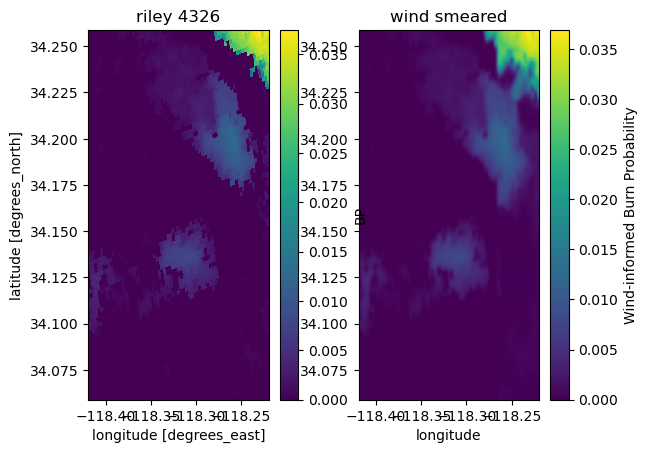

In [30]:
fig, axarr = plt.subplots(ncols=2)
riley_30m_4326_bp.sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot(ax=axarr[0])
axarr[0].set_title('riley 4326')
smoothed_bp_original.sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot(ax=axarr[1])
axarr[1].set_title('wind smeared')

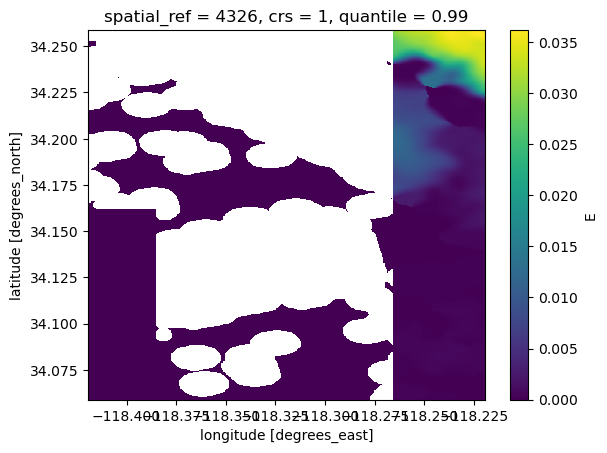

In [34]:
arr_results['E'].sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot()

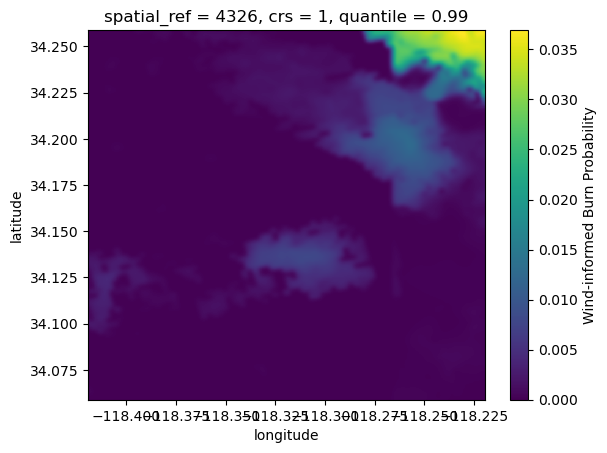

In [28]:
smoothed_bp_original.sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot()

In [14]:
arr_results['S'].sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot()

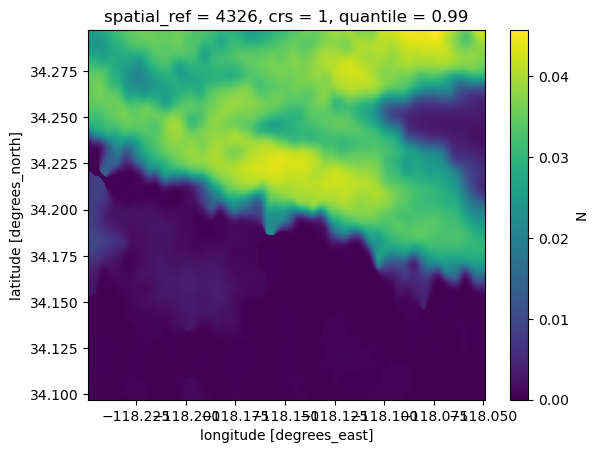

In [15]:
arr_results['N'].sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot()

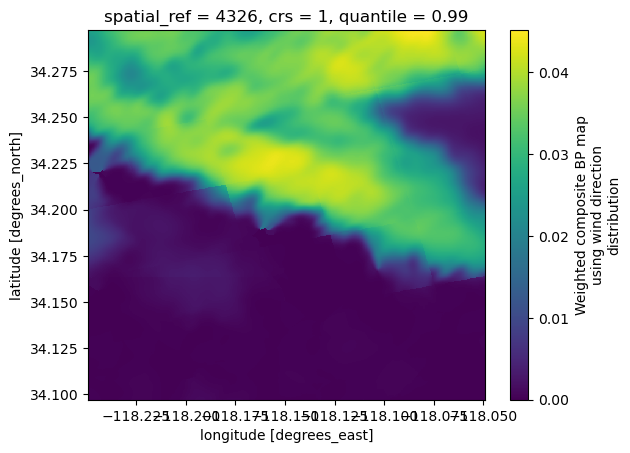

In [21]:
wind_informed_bp_30m_4326.sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot()

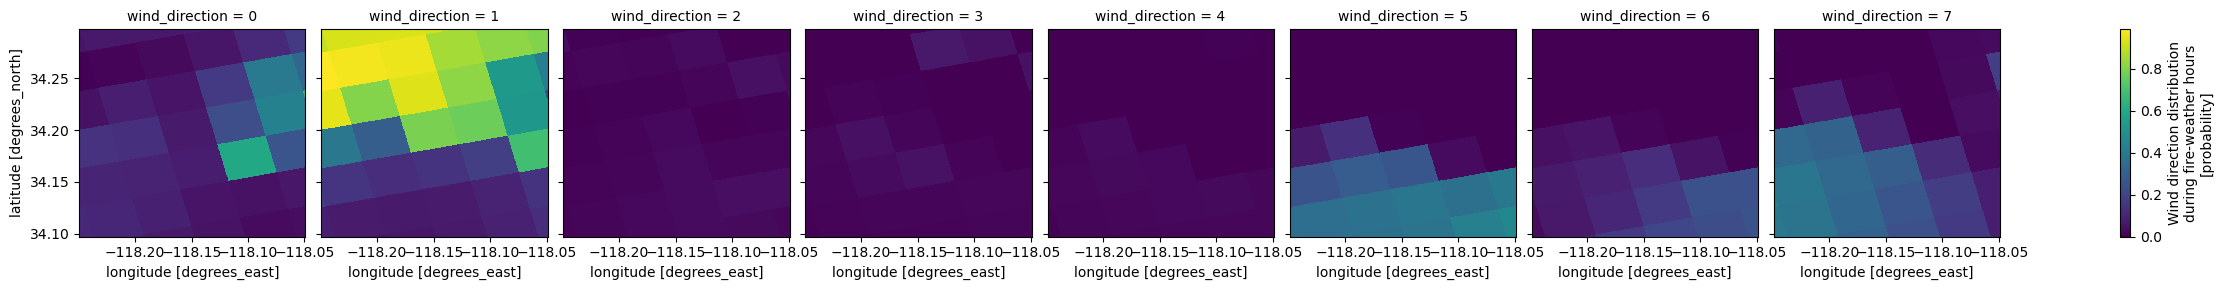

In [13]:
wind_direction_distribution_30m_4326.sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot(col='wind_direction')

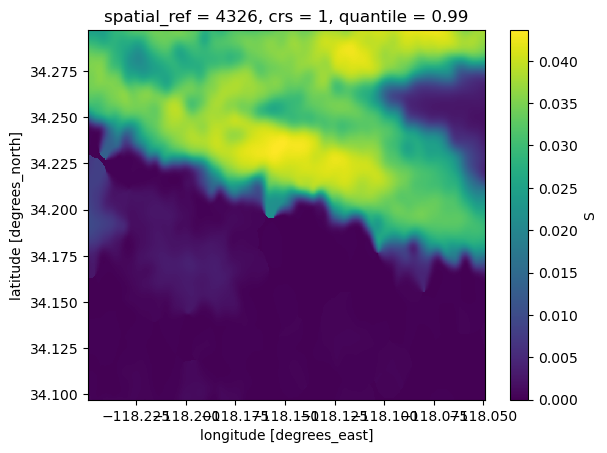

In [18]:
blurred_bp_30m_4326m['S'].sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot()

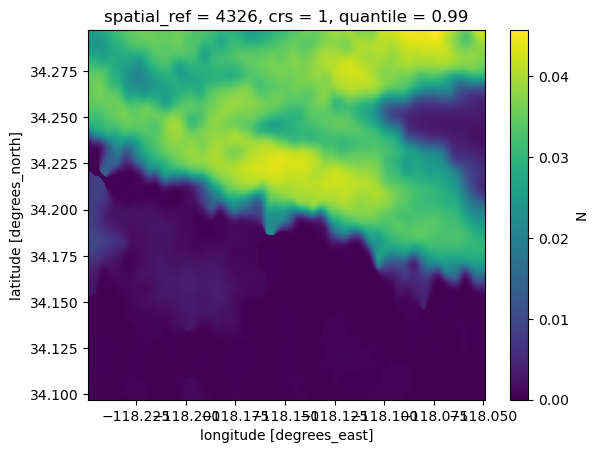

In [19]:
blurred_bp_30m_4326m['N'].sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot()

In [16]:
(blurred_bp_30m_4326m['S']-blurred_bp_30m_4326m['N']).sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot()

# teasing out the spreading

In [58]:
riley_270m_5070

<xarray.Dataset> Size: 6MB
Dimensions:      (y: 997, x: 758)
Coordinates:
  * y            (y) float64 8kB 1.361e+06 1.361e+06 ... 1.629e+06 1.63e+06
  * x            (x) float64 6kB -2.091e+06 -2.09e+06 ... -1.886e+06 -1.886e+06
    spatial_ref  int32 4B 5070
Data variables:
    BP           (y, x) float64 6MB dask.array<chunksize=(997, 758), meta=np.ndarray>

In [148]:
riley_2011_270m_5070_subset['BP'][500, 300] = 1
riley_270m_5070 = riley_2011_270m_5070_subset

with xr.set_options(arithmetic_join='exact'):
    ## gap fill riley 270 only filling NaN pixels which are surrounded by valid data on four sides
    valid_pixels = riley_270m_5070['BP'] > 0
    # shifting will introduce NaNs! So we need to clip along boundaries
    surrounded_by_four_valid_values = (
        valid_pixels.shift(x=1)
        + valid_pixels.shift(x=-1)
        + valid_pixels.shift(y=1)
        + valid_pixels.shift(y=-1)
    ) == 4
    # 270m 5070 projection mask of every pixel which is surrounded by valid data on four sides
    nans_surrounded_by_four_valid_values = xr.where(
        (valid_pixels == 0) & surrounded_by_four_valid_values, 1, 0
    )
    # where nans_surrounded_by_four_valid_values is true, fill with a 3x3 moving window average of valid pixels
    rolling_mean = riley_270m_5070.rolling({'x': 3, 'y': 3}, center=True, min_periods=1).mean(
        skipna=True
    )
    gap_filled_riley_2011_270m_5070_subset = xr.where(
        nans_surrounded_by_four_valid_values, rolling_mean, riley_270m_5070
    )

    wind_direction_distribution_30m_4326 = assign_crs(
        wind_direction_distribution_30m_4326, 'EPSG:4326'
    )
    gap_filled_riley_2011_270m_5070_subset = assign_crs(
        gap_filled_riley_2011_270m_5070_subset, 'EPSG:5070'
    )
    ## reproject to the 30m 4326 projection (use riley_30m_4326 as variable name)
    target_geobox = wind_direction_distribution_30m_4326.odc.geobox
    riley_30m_4326 = xr_reproject(
        gap_filled_riley_2011_270m_5070_subset,
        how=target_geobox,
        resampling='nearest',
    )
    riley_30m_4326 = riley_30m_4326.assign_coords(
        {
            'latitude': wind_direction_distribution_30m_4326.latitude,
            'longitude': wind_direction_distribution_30m_4326.longitude,
        })

In [149]:
iterations = 1
kernel_size = 81.0
circle_diameter = 35.0
da = riley_30m_4326['BP']
import cv2 as cv

    # TODO: must scale the size of the kernel according to the latitude. Can either
    # be done before entering this function to calculate the kernel_size
    # argument or inside this function and pass latitude into the convolution
    # instead and calculate the kernel size here.
weights_dict = generate_wind_directional_kernels(
    kernel_size=kernel_size, circle_diameter=circle_diameter
)
# do the spreading in each of the 8 directions with the correct weights
# TODO: @orianac, do we want to support dask arrays here?
# initialize dataset with the original burn probability
spread_results = xr.Dataset(
    data_vars={var_name: (da.dims, da.values) for var_name in weights_dict.keys()},
    coords=da.coords,
    attrs=da.attrs,
)
# Preserve any CRS-related coordinates
for coord in ['spatial_ref', 'crs']:
    if coord in da.coords:
        spread_results = spread_results.assign_coords({coord: da.coords[coord]})

## this part is extra!!!

# arr_dict, convolved_mask_dict, convolved_arr_dict = {}, {}, {}

# arr_results = xr.Dataset(
#     data_vars={var_name: (da.dims, da.values) for var_name in weights_dict.keys()},
#     coords=da.coords,
#     attrs=da.attrs,
# )
# convolved_mask_results = xr.Dataset(
#     data_vars={var_name: (da.dims, da.values) for var_name in weights_dict.keys()},
#     coords=da.coords,
#     attrs=da.attrs,
# )

# convolved_arr_results = xr.Dataset(
#     data_vars={var_name: (da.dims, da.values) for var_name in weights_dict.keys()},
#     coords=da.coords,
#     attrs=da.attrs,
# )


    
for direction, weights in weights_dict.items():
    # arr_dict[direction], convolved_mask_dict[direction], convolved_arr_dict[direction] = {}, {}, {}
    arr = spread_results[direction].values
    for _ in range(iterations):
        valid_mask = (arr > 0).astype(np.float32)
        convolved_mask = cv.filter2D(valid_mask, ddepth=-1, kernel=weights)
        # why does `filter2D` produce tiny negatives and tiny positives? we shouldn't have to deal with this
        # if we do clip we should ensure we're only clipping VERY small numbers (e.g. e-12)
        convolved_mask = np.where(convolved_mask < 10e-10, 0.0, convolved_mask)

        convolved_arr = cv.filter2D(arr, ddepth=-1, kernel=weights)
        convolved_arr = np.where(convolved_arr < 10e-10, 0.0, convolved_arr)
        arr = np.where(convolved_mask > 0, convolved_arr / convolved_mask, 0.0)
        # ## these are new!! ====
        # arr_dict[direction][_] = arr
        # convolved_mask_dict[direction][_] = convolved_mask
        # convolved_arr_dict[direction][_] = convolved_arr
         ## ====

    # clip residual tiny negatives
    arr = np.where(arr < 0, 0.0, arr)
    spread_results[direction] = (da.dims, arr.astype(np.float32))

    # ## these are new!! ====
    # arr_results[direction] = (da.dims, arr_dict[direction][2].astype(np.float32))
    # convolved_mask_results[direction] = (da.dims, convolved_mask_dict[direction][2].astype(np.float32))
    # convolved_arr_results[direction] = (da.dims, convolved_arr_dict[direction][2].astype(np.float32))

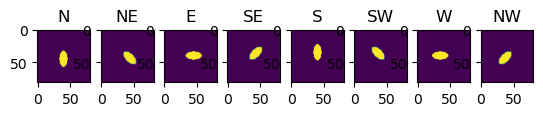

In [146]:
fig, axarr = plt.subplots(ncols=8)
for i, direction in enumerate(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']):
    axarr[i].imshow(weights_dict[direction])
    axarr[i].set_title(direction)

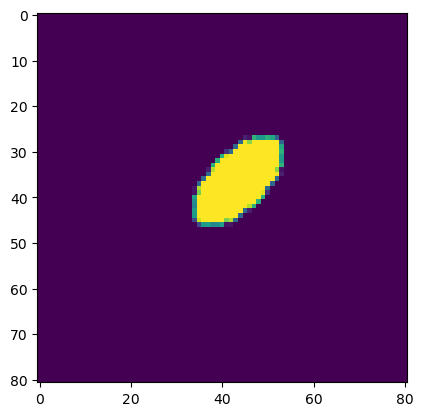

In [141]:
xr.DataArray(weights_dict['NE']).values)

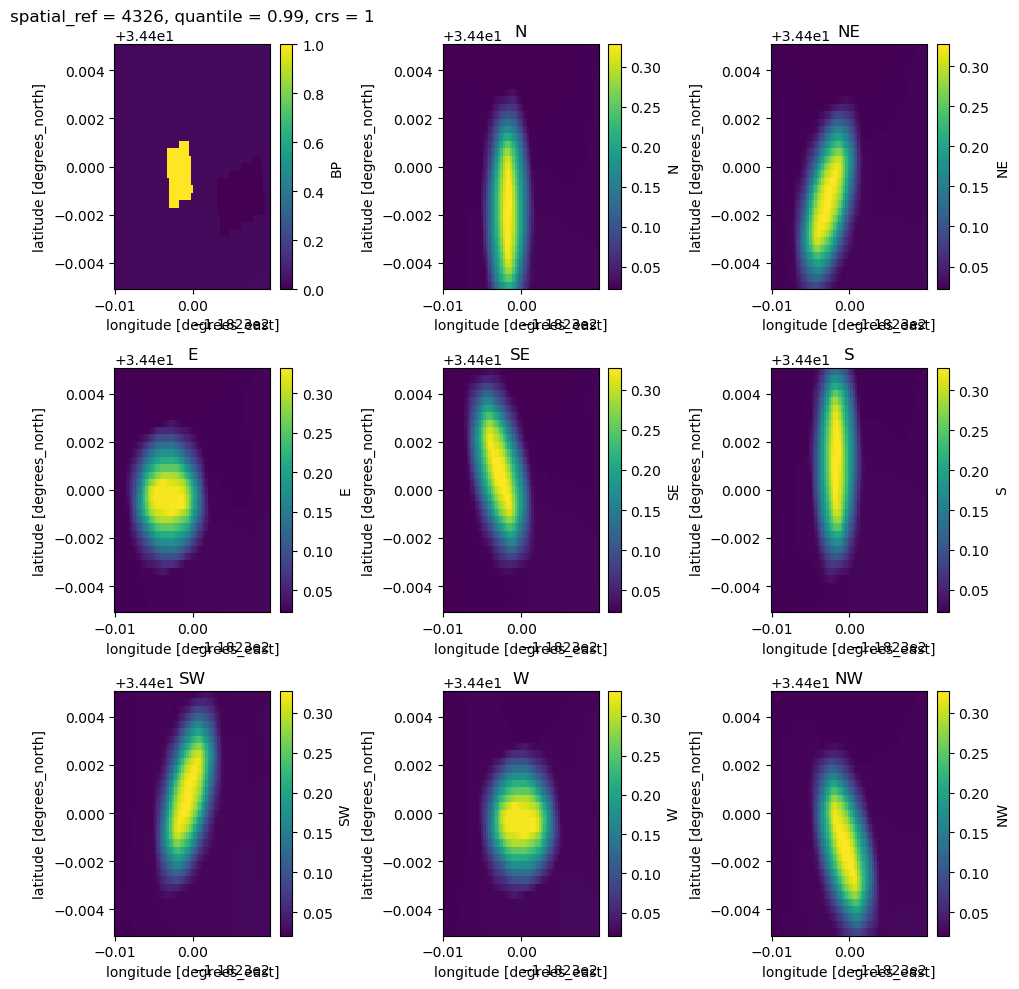

In [150]:
fig, axarr = plt.subplots(ncols=3, figsize=(10,10), nrows=3)

riley_30m_4326['BP'].sel(latitude=slice(34.395, 34.405), longitude=slice(-118.24, -118.22)).plot(ax=axarr.flatten()[0])
for i, direction in enumerate(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']):
    spread_results[direction].sel(latitude=slice(34.395, 34.405), longitude=slice(-118.24, -118.22)).plot(ax=axarr.flatten()[i+1])
    axarr.flatten()[i+1].set_title(direction)
plt.tight_layout()

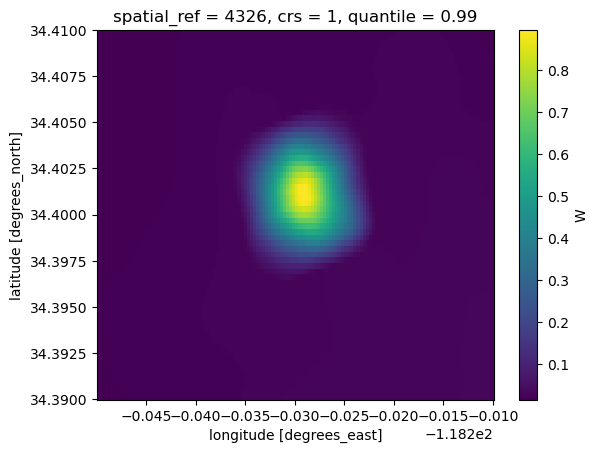

In [89]:
spread_results['W'].sel(latitude=slice(34.39, 34.41), longitude=slice(-118.25, -118.21)).plot()

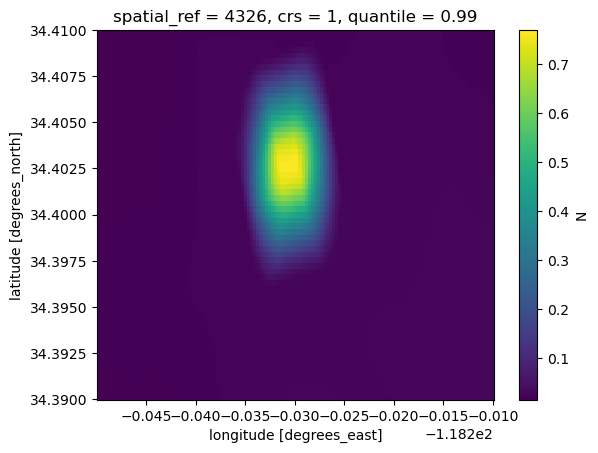

In [90]:
spread_results['N'].sel(latitude=slice(34.39, 34.41), longitude=slice(-118.25, -118.21)).plot()


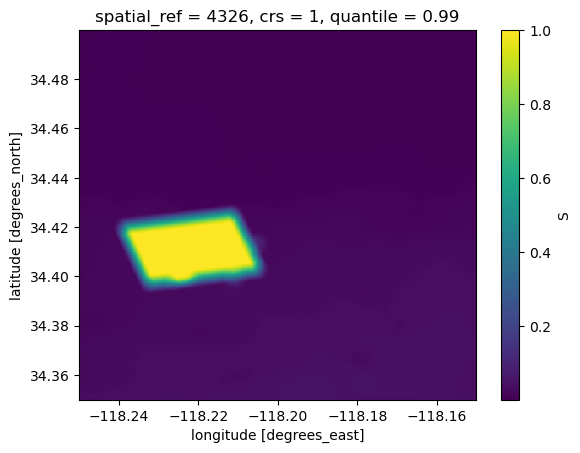

In [80]:
spread_results['S'].sel(latitude=slice(34.35, 34.5), longitude=slice(-118.25, -118.15)).plot()


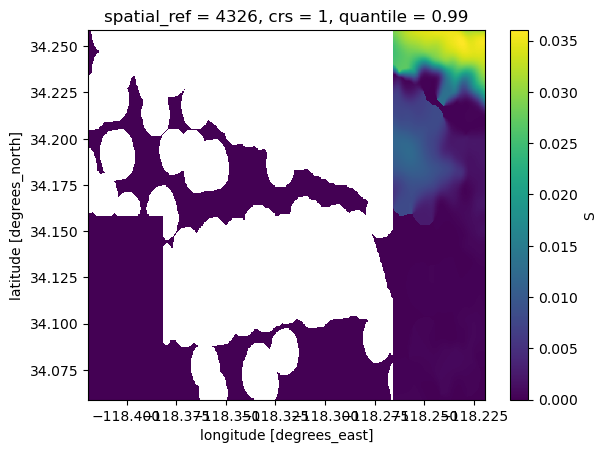

In [18]:
blurred_bp_30m_4326m['S'].sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot()

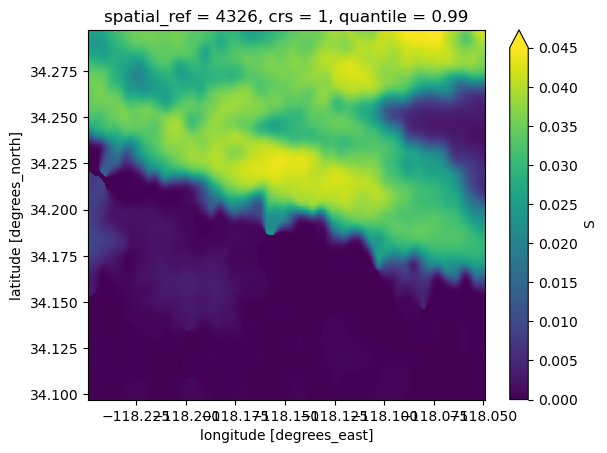

In [24]:
blurred_bp_30m_4326m['S'].sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot(vmin=0, vmax=0.045)

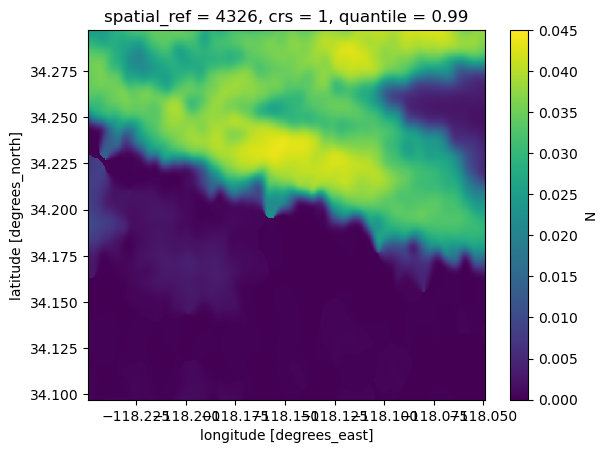

In [25]:
blurred_bp_30m_4326m['N'].sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot(vmin=0, vmax=0.045)

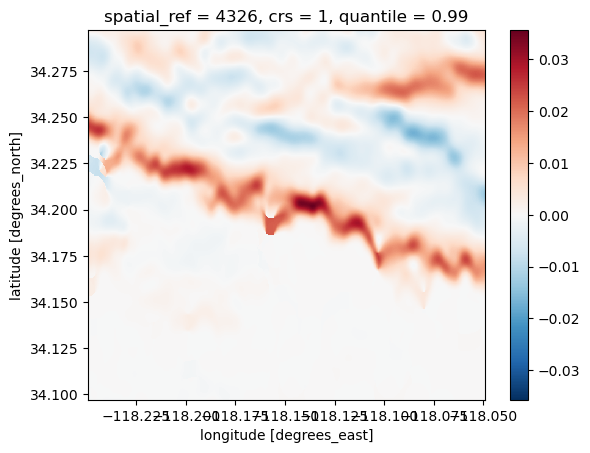

In [23]:
(blurred_bp_30m_4326m['S']-blurred_bp_30m_4326m['N']).sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot()

In [27]:
riley_30m_4326_bp.sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot()

In [29]:
(smoothed_bp-riley_30m_4326_bp).sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot()

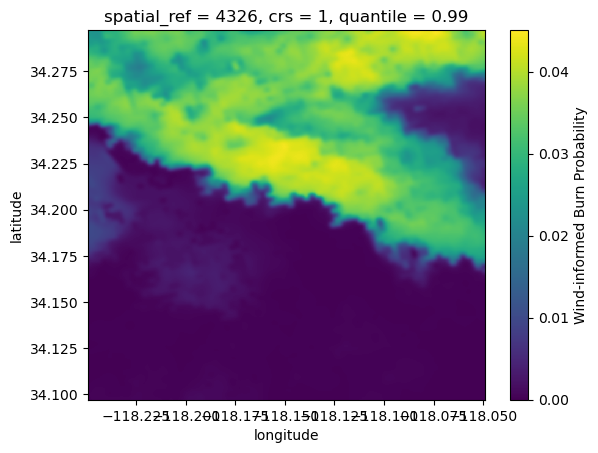

In [26]:
smoothed_bp.sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot()

In [ ]:
blurred_bp_30m_4326m['N'].sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot(vmin=0, vmax=0.045)

In [ ]:
blurred_bp_30m_4326m['S'].sel(latitude=slice(lat-.1, lat+.1), longitude=slice(lon-.1, lon+.1)).plot()

In [15]:
blurred_bp_30m_4326m['N'].sel(latitude=slice(34.4, 34.5), longitude=slice(-118, -117.5)).plot()

In [7]:
riley_30m_4326_bp.isnull().sum().values

array(65)

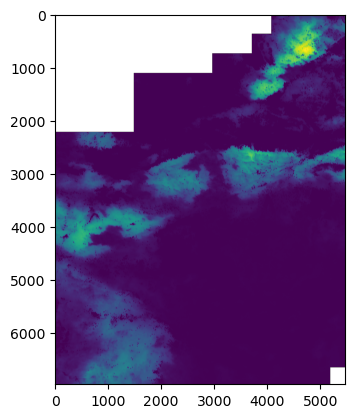

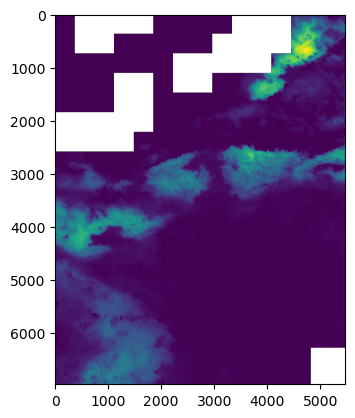

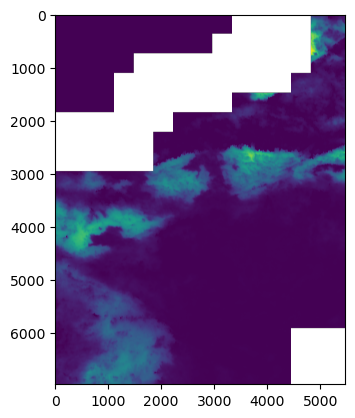

In [6]:
import matplotlib.pyplot as plt
for i in [0,1,2]:
    plt.imshow(convolved_arr_dict[i])
    plt.show()

In [7]:
blurred_bp_30m_4326m['N'].plot()

In [11]:
blurred_bp_30m_4326m['S'].plot()

In [ ]:
blurred_bp_30m_4326m['S']

In [36]:
plt.imshow(arr_dict[0])

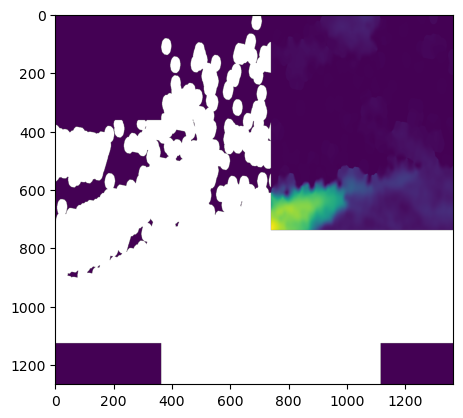

In [37]:
plt.imshow(arr_dict[1])

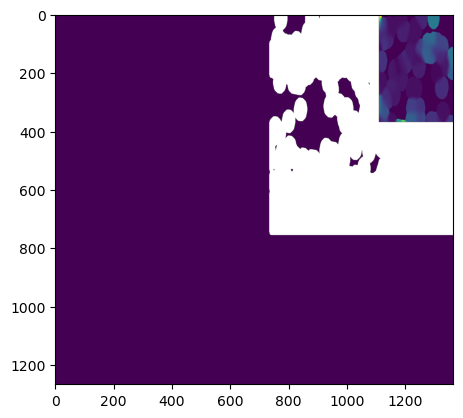

In [38]:
plt.imshow(arr_dict[2])

In [7]:
wind_direction_distribution_30m_4326.plot(col='wind_direction')

In [ ]:
y_slice = slice(34.14, 34.23)
x_slice = slice(-118.18, -118.06)


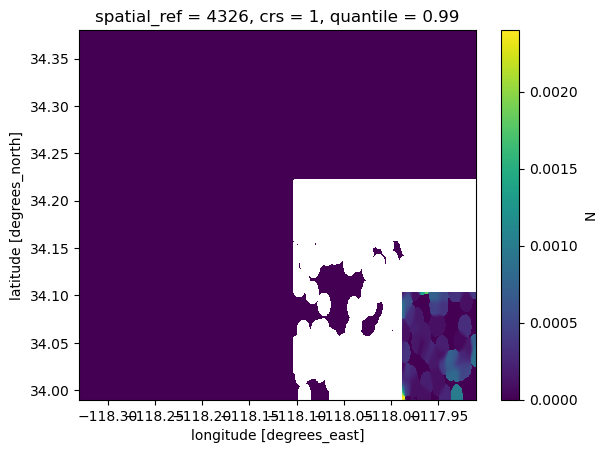

In [9]:
blurred_bp_30m_4326['N'].plot()

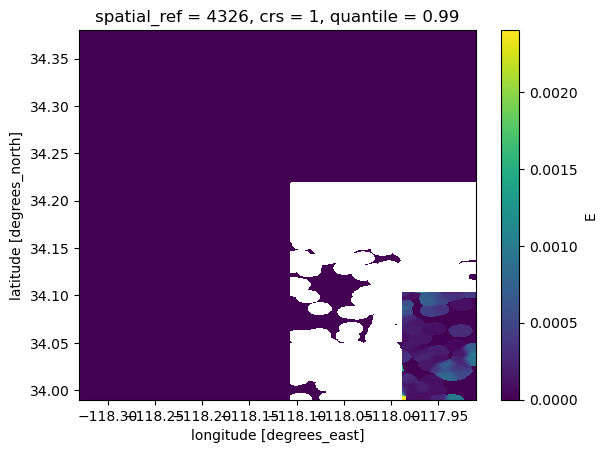

In [10]:
blurred_bp_30m_4326['E'].plot()

In [11]:
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(ncols=9, figsize=(40,5))
for i, var_name in enumerate(blurred_bp_30m_4326m.data_vars):
    blurred_bp_30m_4326m[var_name].plot(ax=axarr[i])

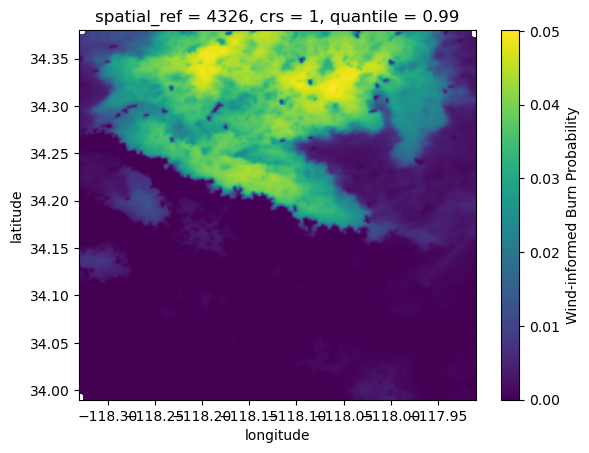

In [22]:
smoothed_bp.plot()